In [ ]:
"""
RNN: 순환 신경망
-이전 셀에서 출력된 값이 다음 셀에서도 출력
-one to many = 입력데이터 하나 -> 여러개 출력(image captioning : image가 들어가면 image에 대한 설명 출력)
-many to one = 입력 여러개 -> 출력 하나 - 가장 오른쪽에 있는 셀에서 출력(ex: 감성분류 -> 영화 재밌었다는 댓글들은 긍정으로 출력)
-many to many = 여러개 입력 -> 여러개 출력 - 다양한 셀에서 출력(ex: 번역기)

old state = 이전셀의 출력값(ht-1)
t시점에서의 입력값(xt)
*입력 계층 입력값  차원이 (4,1)이고 출력 계층의 차원이 (1,3)일경우 히든계층의 차원을 정하기 위해 입력계층 차원을 transpose
를 사용해 (1,4)버 변환해주고 히든 계층을 (4,3)차원으로 설정해주면 됨

- 시그모이드 값이 0 : 앞에 있는 정보 제거한다 -> 불필요한 정보가 전달 안되는 기능도 있음
- 시그모이드 값이 1: 앞쪽 정보들 모두 유지한다.


*LSTM : 순서가 중요한 예측  모형 만들때 중요한 알고리즘 + 주가와 같은 시계열 데이터에서 예측하는데 사용

return_sequences = 다 대 다 구조에서는 return_sequences=True로 한다.
-> 위로 올라갈곳 있으면 True, 올라갈곳이 한군데면 False로 설정
timesteps = input_length(입력 길이)
input_dim = 입력 차원
hidden_units = 은닉 상태의 크기(출력차원)

양방향 RNN : 첫번째 메모리셀 = 앞시점의 은닉 상태 전달받아 현재 은닉 상태 계산
             두번째 메모리셀 = 뒤시점의 은닉 상태 전달 받아 현재 은닉 상태 계산
"""

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [31]:
hyundai_bio=fdr.DataReader('048410')

In [32]:
hyundai_bio

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-08-08,163580,163580,163580,163581,1113828,NaN
2002-08-09,166096,178632,152931,156060,12373472,-0.045977
2002-08-12,162950,162950,151670,152299,3066106,-0.024100
2002-08-13,153562,157317,147922,149166,7598946,-0.020571
2002-08-14,147284,151668,147284,147285,4719858,-0.012610
...,...,...,...,...,...,...
2023-11-01,37250,39550,37200,38350,715446,0.025401
2023-11-02,39200,39250,35900,37200,857043,-0.029987
2023-11-03,36750,36750,30050,31200,3625279,-0.161290


In [33]:
fdr.DataReader('048410','2005-01-01','2009-01-01')

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2005-01-03,75212,75212,73328,73329,311581,-0.008478
2005-01-04,73341,74597,73341,73956,516091,0.008551
2005-01-05,74593,76477,73336,75836,438852,0.025421
2005-01-06,78976,84615,78348,82103,1807384,0.082639
2005-01-07,81491,83991,79607,80851,667762,-0.015249
...,...,...,...,...,...,...
2008-12-23,3420,3489,3210,3280,501944,-0.040936
2008-12-24,3280,3350,3071,3071,849107,-0.063720
2008-12-26,3210,3210,3001,3071,619062,0.000000


In [34]:
fdr.DataReader('BTC/KRW')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,4.826118e+05,4.838110e+05,4.681210e+05,4.732035e+05,4.732035e+05,21787470960
2014-09-18,4.727130e+05,4.762765e+05,4.309914e+05,4.428182e+05,4.428182e+05,35976322560
2014-09-19,4.424667e+05,4.475154e+05,4.012784e+05,4.119893e+05,4.119893e+05,39571102935
2014-09-20,4.118610e+05,4.417305e+05,4.068624e+05,4.267118e+05,4.267118e+05,38469009780
2014-09-21,4.258571e+05,4.303872e+05,4.103040e+05,4.161897e+05,4.161897e+05,27737663355
...,...,...,...,...,...,...
2023-11-03,4.778487e+07,4.818440e+07,4.589860e+07,4.661862e+07,4.661862e+07,28018157917905
2023-11-04,4.662427e+07,4.662427e+07,4.500898e+07,4.546514e+07,4.546514e+07,22460677199165
2023-11-05,4.547037e+07,4.615068e+07,4.531377e+07,4.592312e+07,4.592312e+07,12515877610681


In [35]:
hyundai_bio.index

DatetimeIndex(['2002-08-08', '2002-08-09', '2002-08-12', '2002-08-13',
               '2002-08-14', '2002-08-16', '2002-08-19', '2002-08-20',
               '2002-08-21', '2002-08-22',
               ...
               '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-30',
               '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03',
               '2023-11-06', '2023-11-07'],
              dtype='datetime64[ns]', name='Date', length=5254, freq=None)

In [36]:
hyundai_bio['year']=hyundai_bio.index.year
hyundai_bio['month']=hyundai_bio.index.month
hyundai_bio['day']=hyundai_bio.index.day

In [37]:
hyundai_bio

,Open,High,Low,Close,Volume,Change,year,month,day
Date,,,,,,,,,
2002-08-08,163580,163580,163580,163581,1113828,NaN,2002,8,8
2002-08-09,166096,178632,152931,156060,12373472,-0.045977,2002,8,9
2002-08-12,162950,162950,151670,152299,3066106,-0.024100,2002,8,12
2002-08-13,153562,157317,147922,149166,7598946,-0.020571,2002,8,13
2002-08-14,147284,151668,147284,147285,4719858,-0.012610,2002,8,14
...,...,...,...,...,...,...,...,...,...
2023-11-01,37250,39550,37200,38350,715446,0.025401,2023,11,1
2023-11-02,39200,39250,35900,37200,857043,-0.029987,2023,11,2
2023-11-03,36750,36750,30050,31200,3625279,-0.161290,2023,11,3


Text(0, 0.5, 'price')

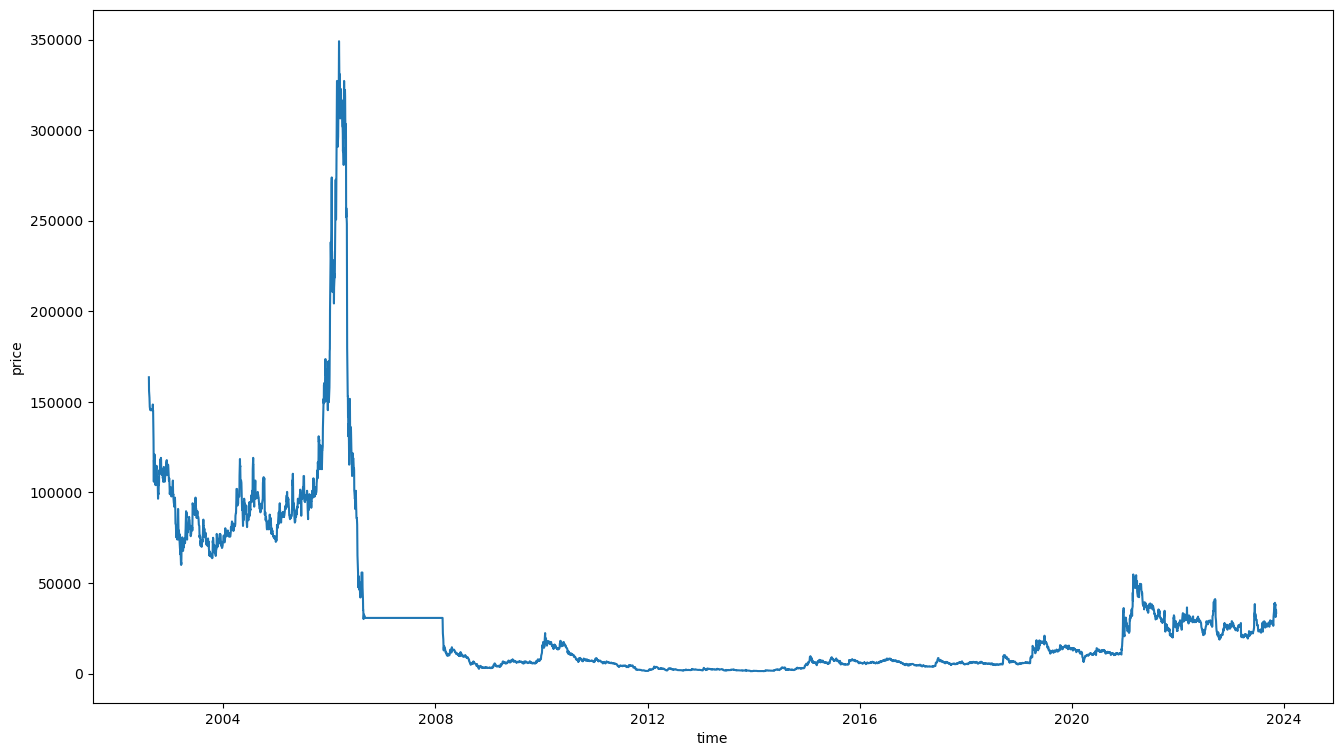

In [38]:
plt.figure(figsize=(16,9))
sns.lineplot(y=hyundai_bio['Close'],x=hyundai_bio.index)
plt.xlabel('time')
plt.ylabel('price')

In [39]:
ts=[['2000','2010'],
    ['2010','2015'],
    ['2015','2020'],
    ['2020','2023']]

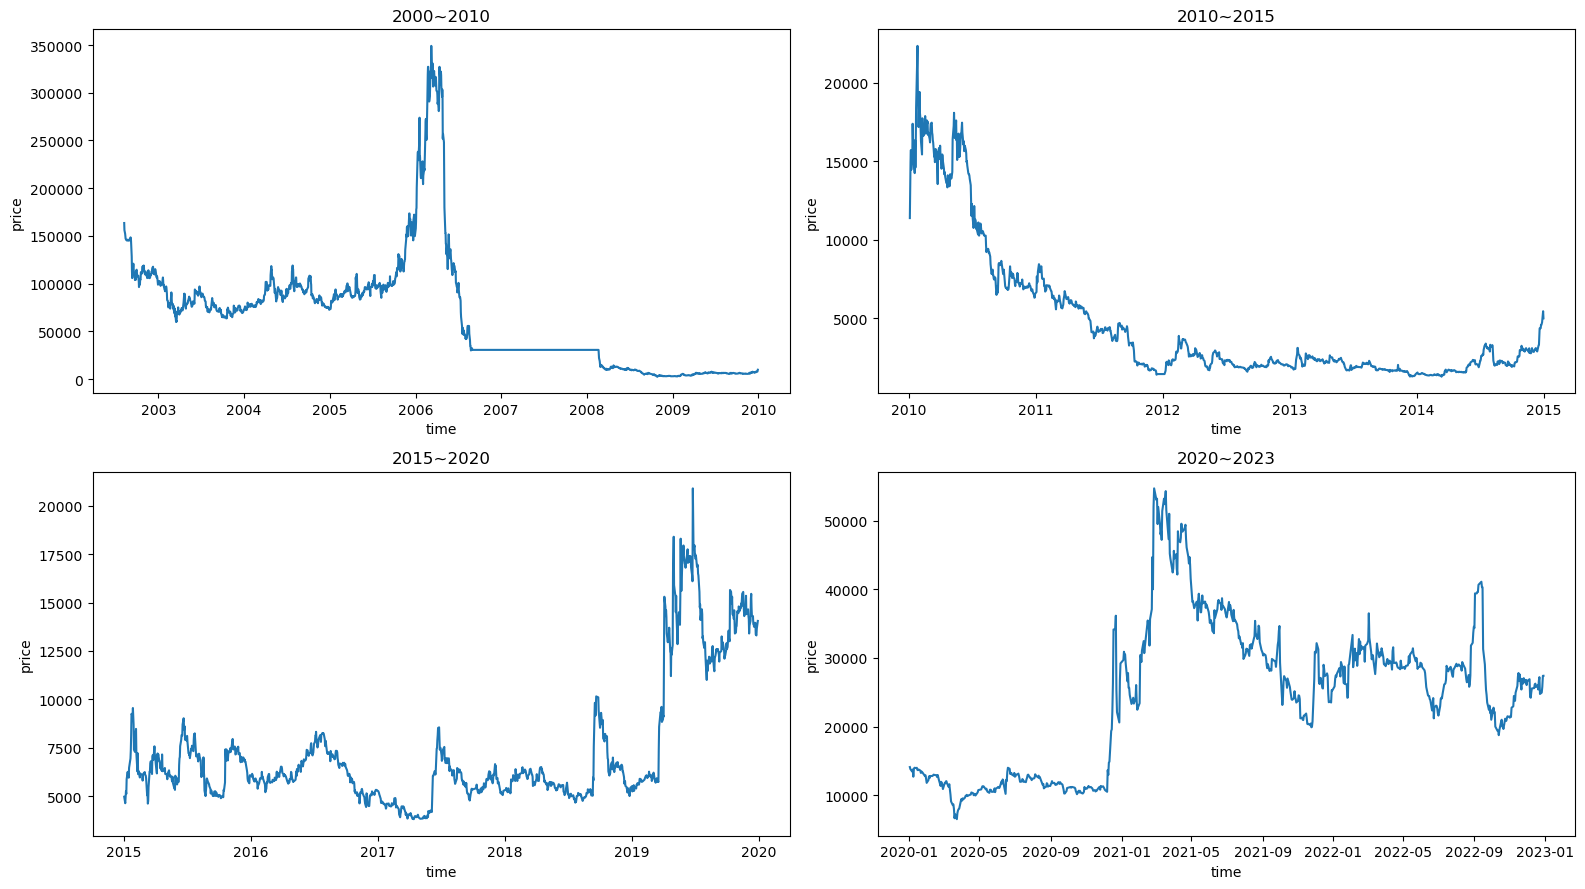

In [40]:
fig, axes=plt.subplots(2,2)
fig.set_size_inches(16,9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = hyundai_bio.loc[(hyundai_bio.index > ts[i][0]) & (hyundai_bio.index <ts[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{ts[i][0]}~{ts[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()

In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [44]:
scaled=scaler.fit_transform(hyundai_bio[cols])
scaled

array([[0.47194798, 0.45787638, 0.49058007, 0.4666199 , 0.01182291],
       [0.47920694, 0.5000084 , 0.45864348, 0.44499615, 0.13134021],
       [0.47013035, 0.45611295, 0.45486172, 0.43418283, 0.03254568],
       ...,
       [0.10602817, 0.10286684, 0.09012062, 0.08600911, 0.03848111],
       [0.09261236, 0.10496616, 0.09521896, 0.09750957, 0.03026956],
       [0.10227751, 0.10006774, 0.09896774, 0.09262188, 0.0104812 ]])

In [45]:
df=pd.DataFrame(scaled,columns=cols)

In [46]:
df

,Open,High,Low,Close,Volume
0,0.471948,0.457876,0.490580,0.466620,0.011823
1,0.479207,0.500008,0.458643,0.444996,0.131340
2,0.470130,0.456113,0.454862,0.434183,0.032546
3,0.443045,0.440346,0.443621,0.425175,0.080660
4,0.424932,0.424534,0.441708,0.419767,0.050100
...,...,...,...,...,...
5249,0.107471,0.110704,0.111564,0.106566,0.007594
5250,0.113097,0.109865,0.107665,0.103260,0.009097
5251,0.106028,0.102867,0.090121,0.086009,0.038481
5252,0.092612,0.104966,0.095219,0.097510,0.030270


In [47]:
from sklearn.model_selection import train_test_split

In [48]:
#close 제외한 나머지가 독립변수, close가 종속변수
xtrain, xtest, ytrain, ytest=train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False )

C:\Users\user\AppData\Local\Temp\ipykernel_1380\31551705.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  xtrain, xtest, ytrain, ytest=train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False )


In [49]:
xtrain.shape

(4203, 4)

In [50]:
xtest.shape

(1051, 4)

In [51]:
ytrain.shape

(4203,)

In [52]:
#RNN

In [53]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):  #4203 - 20 = 4183 => i= 0,4182
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [54]:
xtrain, ytrain = make_dataset(xtrain, ytrain, 20)

In [57]:
xtrain.shape    #4183개의 윈도우, 하나의 윈도우당 20일동안 수집된 주가 데이터

(4183, 20, 4)

In [59]:
ytrain.shape
ytrain=ytrain.reshape(ytrain.shape[0],1)

In [60]:
ytrain.shape

(4183, 1)

In [61]:
xtest.shape

(1051, 4)

In [62]:
ytest.shape

(1051,)

In [65]:
xtest, ytest = make_dataset(xtest, ytest, 20)

In [66]:
xtest.shape

(1031, 20, 4)

In [67]:
ytest=ytest.reshape(ytest.shape[0],1)

In [68]:
ytest.shape

(1031, 1)

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [70]:
model = Sequential()

In [71]:
model.add(LSTM(16,
               input_shape=(xtrain.shape[1],xtrain.shape[2]),
              activation='relu',
              return_sequences=False))      #hidden_unit, 입력데이터 shape(xtrain 데이터의 각 윈동우데이터의 shape),
                                            #출력이 하나이므로 return_sequences = False

In [72]:
model.add(Dense(1))   #예측 문제임으로 linear을 활성화함수로 사용한다 + linear은 default값임으로 안써도 됨

In [73]:
model.compile(loss='mean_squared_error', optimizer='adam') 
#loss는 연속형 값을 에측하는 문제임으로 mse사용 
early_stop = EarlyStopping(monitor='val_loss', patience=5)
#val_loss기준으로 5번 참음
checkpoint = ModelCheckpoint('tmp_checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [74]:
xtrain, x_valid, ytrain, y_valid = train_test_split(xtrain, ytrain, test_size=0.2)

In [75]:
history = model.fit(xtrain, ytrain, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
199/210 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 1: val_loss improved from inf to 0.00033, saving model to tmp_checkpoint.h5
210/210 [==============================] - 2s 5ms/step - loss: 0.0010 - val_loss: 3.2994e-04
Epoch 2/200
 40/210 [====>.........................] - ETA: 0s - loss: 2.9551e-04

C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/210 [===========================>..] - ETA: 0s - loss: 3.0701e-04
Epoch 2: val_loss improved from 0.00033 to 0.00021, saving model to tmp_checkpoint.h5
210/210 [==============================] - 1s 4ms/step - loss: 3.0716e-04 - val_loss: 2.1193e-04
Epoch 3/200
199/210 [===========================>..] - ETA: 0s - loss: 3.1629e-04
Epoch 3: val_loss did not improve from 0.00021
210/210 [==============================] - 1s 5ms/step - loss: 3.1290e-04 - val_loss: 2.5271e-04
Epoch 4/200
204/210 [============================>.] - ETA: 0s - loss: 2.5570e-04
Epoch 4: val_loss improved from 0.00021 to 0.00019, saving model to tmp_checkpoint.h5
210/210 [==============================] - 1s 4ms/step - loss: 2.5208e-04 - val_loss: 1.9356e-04
Epoch 5/200
200/210 [===========================>..] - ETA: 0s - loss: 2.3937e-04
Epoch 5: val_loss improved from 0.00019 to 0.00016, saving model to tmp_checkpoint.h5
210/210 [==============================] - 1s 5ms/step - loss: 2.3293e-04 - val_loss: 1.

In [76]:
model.load_weights('tmp_checkpoint.h5')

In [77]:
pred=model.predict(xtest)

33/33 [==============================] - 0s 2ms/step


In [78]:
pred

array([[0.0310743 ],
       [0.03132966],
       [0.03148843],
       ...,
       [0.10645854],
       [0.10430703],
       [0.1006218 ]], dtype=float32)

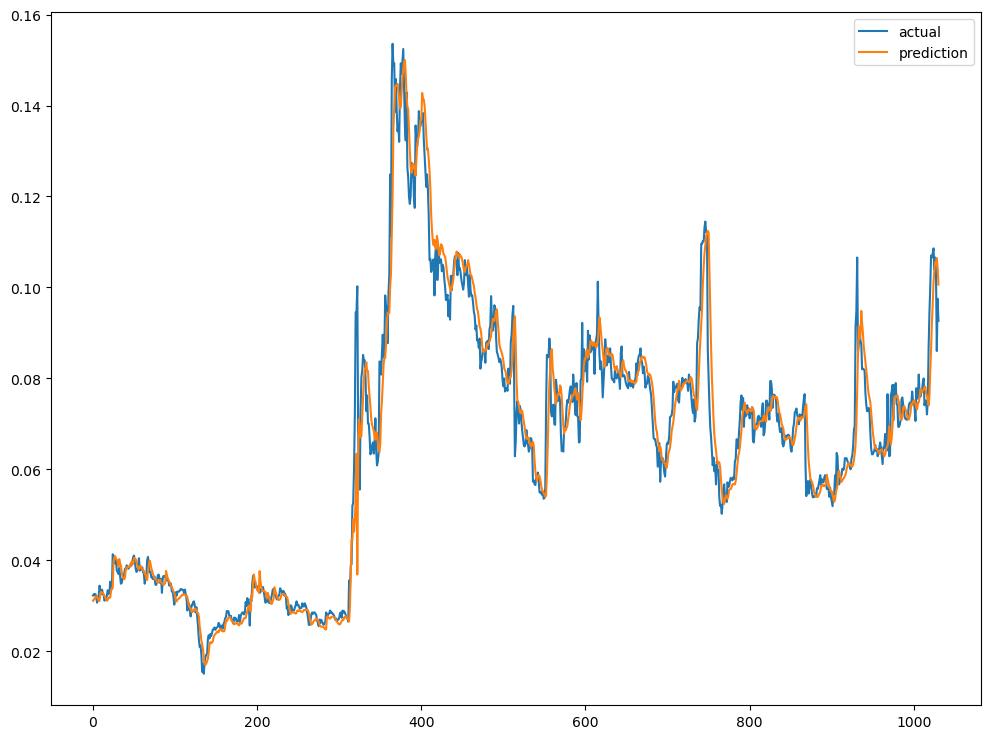

In [79]:
plt.figure(figsize=(12, 9))
plt.plot(ytest, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [82]:
df = pd.DataFrame(scaled, columns=cols)                            
xtrain,xtest,ytrain,ytest = train_test_split(df.drop("Close",axis = 1),df['Close'], test_size=0.2, random_state=0, shuffle=False)
vsta = np.hstack([xtest[20:],pred])
ans = scaler.inverse_transform(vsta)
ans[:,1]

array([12800., 12800., 13100., ..., 36750., 37500., 35750.])

In [ ]:
##################

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN

model = Sequential()
model.add(SimpleRNN(3, input_shape=(2,10))) # -> 출력이 3차원
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일함.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 42        
                                                                 
Total params: 42 (168.00 Byte)
Trainable params: 42 (168.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
import numpy as np

timesteps = 10
input_dim = 4
hidden_units = 8

# 입력에 해당되는 2D 텐서
inputs = np.random.random((timesteps, input_dim))

# 초기 은닉 상태는 0(벡터)로 초기화
hidden_state_t = np.zeros((hidden_units,)) 

print('초기 은닉 상태 :',hidden_state_t)

초기 은닉 상태 : [0. 0. 0. 0. 0. 0. 0. 0.]


In [45]:
Wx = np.random.random((hidden_units, input_dim))  # (8, 4)크기의 2D 텐서 생성. 입력에 대한 가중치.
Wh = np.random.random((hidden_units, hidden_units)) # (8, 8)크기의 2D 텐서 생성. 은닉 상태에 대한 가중치.
b = np.random.random((hidden_units,)) # (8,)크기의 1D 텐서 생성. 이 값은 편향(bias).

print('가중치 Wx의 크기(shape) :',np.shape(Wx))
print('가중치 Wh의 크기(shape) :',np.shape(Wh))
print('편향의 크기(shape) :',np.shape(b))

가중치 Wx의 크기(shape) : (8, 4)
가중치 Wh의 크기(shape) : (8, 8)
편향의 크기(shape) : (8,)


In [ ]:
"""
timesteps = 10 -> 입력데이터가 10개
input_dim = 4  -> 입력데이터 차원이 4차원
hidden_units = 8 -> 출력 차원이 8차원

"""

In [46]:
total_hidden_states = []

# 각 시점 별 입력값.
for input_t in inputs:

  # Wx * Xt + Wh * Ht-1 + b(bias)
  output_t = np.tanh(np.dot(Wx,input_t) + np.dot(Wh,hidden_state_t) + b)

  # 각 시점 t별 메모리 셀의 출력의 크기는 (timestep t, output_dim)
  # 각 시점의 은닉 상태의 값을 계속해서 누적
  total_hidden_states.append(list(output_t))
  hidden_state_t = output_t

# 출력 시 값을 깔끔하게 해주는 용도.
total_hidden_states = np.stack(total_hidden_states, axis = 0) 

# (timesteps, output_dim)
print('모든 시점의 은닉 상태 :')
print(total_hidden_states)

모든 시점의 은닉 상태 :
[[0.67570346 0.97746368 0.97397909 0.91135559 0.9677784  0.969452
  0.72521689 0.87059406]
 [0.99990776 0.9999851  0.99984835 0.99993869 0.99998166 0.99998248
  0.99619975 0.99989617]
 [0.99991801 0.99999418 0.99992528 0.99997542 0.99999129 0.99999406
  0.99797119 0.99995336]
 [0.99991343 0.99999142 0.99986289 0.99995336 0.99998486 0.999989
  0.99739137 0.99994905]
 [0.99995766 0.99999724 0.99995198 0.99998332 0.99999203 0.9999955
  0.99807026 0.99995054]
 [0.99993523 0.99999828 0.99997553 0.99999002 0.99999531 0.99999561
  0.99874623 0.99998737]
 [0.99998821 0.99999936 0.99998958 0.99999589 0.99999713 0.99999813
  0.99904726 0.99998835]
 [0.99994173 0.99999876 0.99997605 0.99999052 0.99999447 0.9999965
  0.99844612 0.99996764]
 [0.99996225 0.99999913 0.99998352 0.99999311 0.99999566 0.99999689
  0.99874511 0.99998257]
 [0.99998723 0.99999961 0.99999343 0.99999739 0.99999785 0.99999878
  0.99912493 0.99998539]]
